## LSTM (Long Short Term Memory) Networks for predicting Time Series
### Author: Sergei Bulaev. ODS Slack: @ser-serege , Fall 2018

### Introduction

In order to understand better the meaning of “Time series Forecast”, let’s split the term in two parts:
1. Time series is a sequence of observations taken sequentially in time.
2. Forecast means making predictions about a future event.

Time Series Forecasting has been in use for quite some time in several industries; It is often used in any industry to guide future decisions, for example, in retail forecasting is very important so that the raw material can be procured accordingly. The best known example is the weather forecast, where the future can be predicted based on the pattern in the past and recent changes. These predictions are very important and usually are the first step to solve other problems.

Traditional Time Series analysis involves decomposing the data into its components such as trend component, seasonal component and noise.
< Techniques such as ARIMA(p,d,q), moving average, auto regression were used to analyze time series. Stateful RNN’s such as LSTM is found to be very effective in Time Series analysis in the recent past.

Neural networks are a very comprehensive family of machine learning models and, in recent years, their applications in finance and economics have dramatically increased.

##### What is RNN or Recurrent Neural Networks?

The idea of Recurrent Neural Networks (RNNs) is to use sequential information. In a traditional neural network, we assume that all inputs are independent. But for many tasks this is not an optimal idea. RNNs are called recurrent because you perform the same task for each element of a sequence, with the output depending on the previous calculations.

RNN is a special case of neural network similar to convolutional neural networks, the difference being that RNN’s can retain its state of information.

##### What is LSTM?

<img src="http://datareview.info/wp-content/uploads/2015/09/1.png" />

LSTM is a variant of the RNN architecture. It was difficult to train models using traditional RNN architectures. Recent advancements demonstrate state of the art results using LSTM(Long Short Term Memory). An LSTM cell has 5 essential components which allows it to model both long-term and short-term data: the cell state, hidden state, input gate, forget gate and output gate. One critical advantage of LSTMs is their ability to remember from long-term sequences.
The LSTM architecture was able to take care of the vanishing gradient problem in the traditional RNN.



The goal of this Tutorial is to provide a practical guide to neural networks for forecasting financial time series data.






###### Using LSTM Flexibility to use multiple combinations of parametres:
1. Many to a model (useful if you want to predict today, taking into account all previous input),
1. Many-to-Many models (useful when predicting multiple future steps at the same time, taking into account all previous inputs)
and a number of other deviations from it.
2. We can personalize several things, for example - the size of the monitoring window that needs to be predicted in the current phase,
3. The number of steps we want to predict in the future
4. Put the current prediction back into the window to do the prediction in the next step (this technique is also known as the progress window).
5.  To define the best LSTM architecture
5. And so on

LSTM networks were presented in the paper Hochreiter and Schmidhuber, 1997,

The first work about LSTM networks was in 1997 by Hochreiter and Schmidhuber to solve the problem of long-term dependencies.

All RNNs have the form of a chain of repeating modules.
<The LSTM network is a similar chain, but the repeating module has a different structure. Instead of a single layer, it contains four layers that interact in a special way. 
    
<img src="http://datareview.info/wp-content/uploads/2015/09/6.png" />
    
###### The main technical idea at LSTM networks 
is that the cell state represented by a horizontal line at the top of the following figure.

The state of the cell can be compared to a conveyor belt. It passes through the entire chain, with only minor linear interactions.
<img src="http://datareview.info/wp-content/uploads/2015/09/8.png" />


The LSTM network has the ability to remove and add information to the cell state. This process is regulated by special structures called gates (gate).
###### Gate 
is a mechanism that allows information to be passed selectively. It consists of a sigmoid layer (activation function-sigmoid) and a point multiplication operation.

<img src="http://datareview.info/wp-content/uploads/2015/09/9.png" />

The output of the sigmoid layer is a number from 0 to 1, which determines the level of transmission. Zero means" don't miss anything "and one means"skip all".  The cell has three gates that control its state.

### The first gate "forget gate"
The first gate decide which information to remove from the cell state. This decision is made by sigmoid-layer.
<img src="http://datareview.info/wp-content/uploads/2015/09/10.png" />

### The second gate 
The second gate decide which new information to write to the cell state. This stage is divided into two parts. First, the sigmoid layer, called the input gate, decides which values need to be updated. The tanh layer then creates a vector of New CT ' candidate values that can be added to the cell state.
<img src="http://datareview.info/wp-content/uploads/2015/09/11.png" />

### The third gate

The third gate decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" />

# Let's start to build a model

In [15]:
import seaborn as sns
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM

import plotly.offline as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### This tuturial will be based on data about real time-series data of total ads watched by hour in one of our games.

In [2]:
df = pd.read_csv('../../data/ads_hour.csv',index_col=['Date'], parse_dates=['Date'])

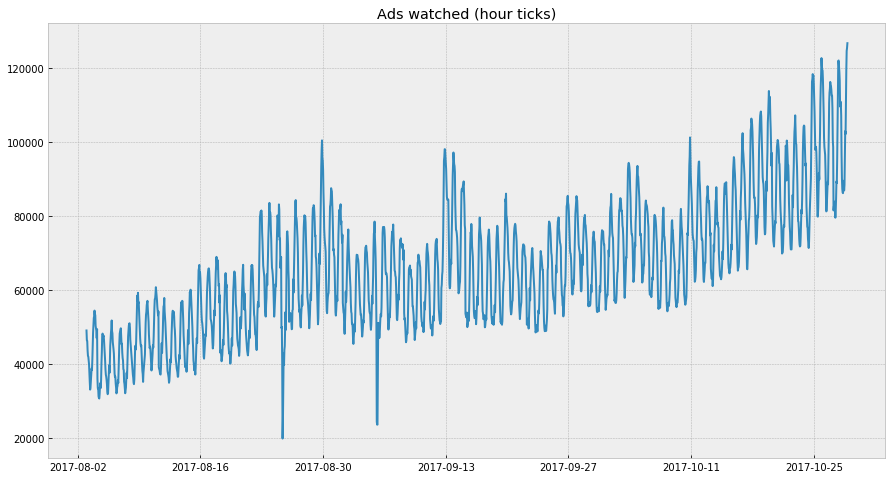

In [3]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Ads watched (hour ticks)')
    plt.plot(df.ads);

In [4]:
df.head()

,ads
Date,
2017-08-03 00:00:00,49136
2017-08-03 01:00:00,46450
2017-08-03 02:00:00,46355
2017-08-03 03:00:00,43748
2017-08-03 04:00:00,42281


### The first step 
We will try approach with window data. 

In [5]:
# Making a function to break data, scale data, window data

def get_window_data(data, window):
    # Get window data and scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data.reshape(-1, 1))

    X = []
    y = []

    for i in range(len(data) - window - 1):
        X.append(data[i : i + window])
        y.append(data[i + window + 1])

    X = np.asarray(X)
    y = np.asarray(y)
    return X, y, scaler


window_size = 50
X, y, scaler = get_window_data(df.values, window_size)

test_split = int(len(df) * 0.8)

X_train = X[:test_split]
X_test = X[test_split:]

y_train = y[:test_split]
y_test = y[test_split:]

## Neural Network structure 

##### Dense 
implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

##### Dropuout 
Applies Dropout to the input.
Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.


##### Optimizer 
SGD (Stochastic gradient descent optimizer. ) , RMSprop (It is recommended to leave the parameters of this optimizer at their default values (except the learning rate, which can be freely tuned). Adam

Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order mo- ments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. The hyper-parameters have intuitive interpre- tations and typically require little tuning.

##### Metrics 
A metric is a function that is used to judge the performance of your model. Metric functions are to be supplied in the metrics parameter when a model is compiled.
It coud be Custom metrics , binary_accuracy, categorical_accuracy. A metric function is similar to a loss function, except that the results from evaluating a metric are not used when training the model. You may use any of the loss functions as a metric function.


##### Loss function
MSE, MAPE, MAE, Cosine_proximity, categorical_crossentropy


##### Activation 
Activations can either be used through an Activation layer, or through the activation argument supported by all forward layers.
It could be: tanh, softmax, relu , sigmoid, exponential, linear

##### Callbacks
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.
We will use "history": callback that records events into a History object. This callback is automatically applied to every Keras model. The History object gets returned by the fit method of models.

In [6]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((1668, 50, 1), (366, 50, 1), (1668, 1), (366, 1))

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM

# ------- Building the LSTM model --------- #

model = Sequential()
model.add(LSTM(50, input_shape=(window_size, 1))) # 50neurons, and and window_size = 50 
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")

# ------- Building the LSTM model --------- #


In [9]:
# We can just fit or write it to history of learning. Then we will see the process of learning

history = model.fit( X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test),
                                                                        verbose=2, shuffle=False)


Train on 1668 samples, validate on 366 samples
Epoch 1/20
 - 6s - loss: 0.0059 - val_loss: 0.0120
Epoch 2/20
 - 6s - loss: 0.0045 - val_loss: 0.0093
Epoch 3/20
 - 6s - loss: 0.0036 - val_loss: 0.0072
Epoch 4/20
 - 6s - loss: 0.0032 - val_loss: 0.0055
Epoch 5/20
 - 6s - loss: 0.0029 - val_loss: 0.0045
Epoch 6/20
 - 8s - loss: 0.0025 - val_loss: 0.0042
Epoch 7/20
 - 8s - loss: 0.0025 - val_loss: 0.0035
Epoch 8/20
 - 7s - loss: 0.0025 - val_loss: 0.0040
Epoch 9/20
 - 7s - loss: 0.0023 - val_loss: 0.0029
Epoch 10/20
 - 8s - loss: 0.0023 - val_loss: 0.0025
Epoch 11/20
 - 7s - loss: 0.0022 - val_loss: 0.0022
Epoch 12/20
 - 7s - loss: 0.0022 - val_loss: 0.0028
Epoch 13/20
 - 6s - loss: 0.0021 - val_loss: 0.0024
Epoch 14/20
 - 8s - loss: 0.0021 - val_loss: 0.0026
Epoch 15/20
 - 7s - loss: 0.0021 - val_loss: 0.0025
Epoch 16/20
 - 7s - loss: 0.0020 - val_loss: 0.0034
Epoch 17/20
 - 7s - loss: 0.0020 - val_loss: 0.0023
Epoch 18/20
 - 7s - loss: 0.0020 - val_loss: 0.0024
Epoch 19/20
 - 7s - loss: 

In [ ]:


mse_lstm = mean_squared_error( scaler.inverse_transform(y_test), scaler.inverse_transform(model.predict(X_test)))
print("RMSE for LSTM {:.2f}".format(np.sqrt(mse_lstm)))

In [16]:
# make functions for plotting history and predictions

def plot_history(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history["loss"],  label="Train")
    plt.plot(history.history["val_loss"], label="Test")
    plt.title("Loss over epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot(X_test):
    pred = model.predict(X_test)
    pred_inverse = scaler.inverse_transform(pred.reshape(-1, 1))
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate mean_squared_error. Previosly we did MinMax scale, so apply inverse_transform to recover values
    rmse = sqrt(mean_squared_error(y_test_inverse, pred_inverse))
    print('Test RMSE: %.3f' % rmse)
    plt.figure(figsize=(15, 8))
    plt.plot(pred_inverse, label='predict')
    plt.plot(y_test_inverse, label='actual')
    plt.legend()
    plt.show()

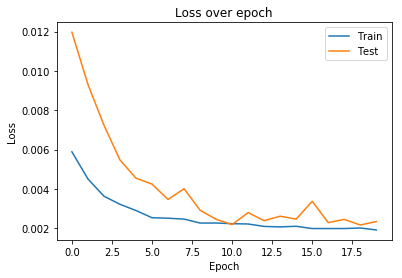

In [11]:
plot_history(history)

Test RMSE: 5160.964


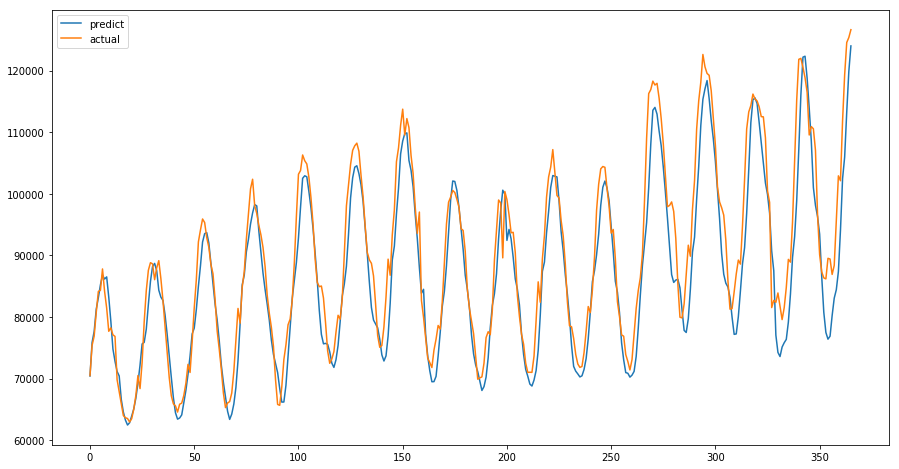

In [17]:
plot(X_test)
plot_history(history)

In [23]:
# So, we got not nice predictions. Lets's try to add return sequences, changenumber of neurons, 
# batch size  and optimizer to rmsprop

# ------- Building the LSTM model --------- #

model = Sequential()
model.add(LSTM(input_dim=1, output_dim=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="rmsprop")

# ------- Building the LSTM model --------- #


In [26]:
# Fitting the model

history = model.fit(X_train, y_train, batch_size=256, nb_epoch=20, validation_data=(X_test, y_test))

Train on 1668 samples, validate on 366 samples
Epoch 1/20
1668/1668 [==============================] - 1s 809us/step - loss: 0.0098 - val_loss: 0.0125
Epoch 2/20
1668/1668 [==============================] - 1s 741us/step - loss: 0.0103 - val_loss: 0.0218
Epoch 3/20
1668/1668 [==============================] - 1s 758us/step - loss: 0.0081 - val_loss: 0.0071
Epoch 4/20
1668/1668 [==============================] - 1s 743us/step - loss: 0.0050 - val_loss: 0.0269
Epoch 5/20
1668/1668 [==============================] - 1s 750us/step - loss: 0.0050 - val_loss: 0.0046
Epoch 6/20
1668/1668 [==============================] - 1s 752us/step - loss: 0.0049 - val_loss: 0.0092
Epoch 7/20
1668/1668 [==============================] - 1s 739us/step - loss: 0.0046 - val_loss: 0.0034
Epoch 8/20
1668/1668 [==============================] - 1s 768us/step - loss: 0.0039 - val_loss: 0.0079
Epoch 9/20
1668/1668 [==============================] - 1s 743us/step - loss: 0.0046 - val_loss: 0.0257
Epoch 10/20
1668/

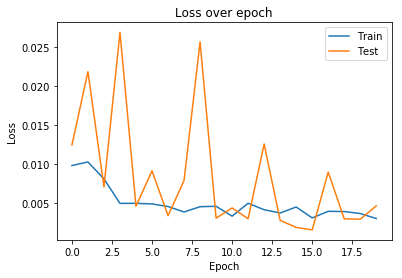

Test RMSE: 7299.535


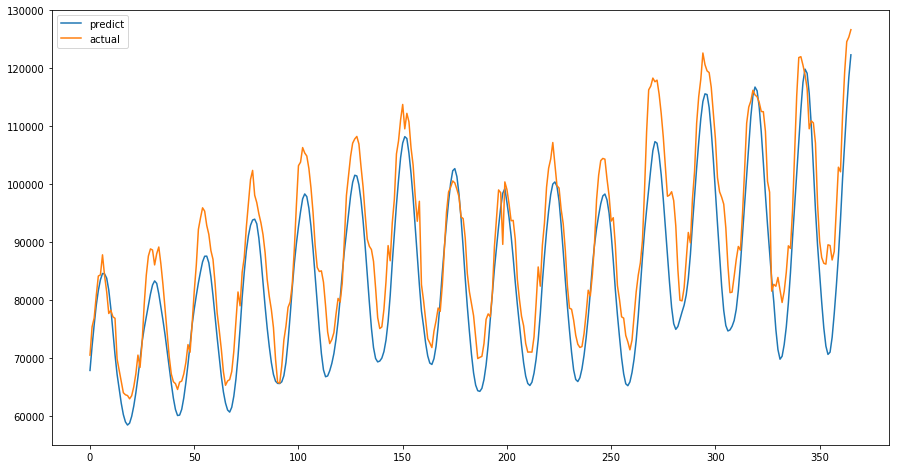

In [27]:
plot_history(history)
plot(X_test)

## Actually not that result that we expect from Neural Network! Keep on trying

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df.values)

In [28]:
df = pd.read_csv('../../data/ads_hour.csv',index_col=['Date'], parse_dates=['Date'])

In [29]:
# Another one approach to break the data using "shift"
# Take bigger window 
window_size = 100

df_s = df.copy()
for i in range(window_size):
    df = pd.concat([df, df_s.shift(-(i+1))], axis = 1)
df.dropna(axis=0, inplace=True)

In [30]:
test_index = round(0.8*df.shape[0])

X = df.iloc[:test_index, :]
y = df.iloc[test_index:,:]

#from sklearn.utils import shuffle
#train = shuffle(train)

X_train = X.iloc[:,:-1]
y_train = X.iloc[:,-1]
X_test = y.iloc[:,:-1]
y_test = y.iloc[:,-1]

#train_X = train_X.values
#train_y = train_y.values
#test_X = test_X.values
#test_y = test_y.values

In [31]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train.values)
X_test= scaler.transform(X_test.values)


scalere = MinMaxScaler(feature_range=(-1, 1))
y_train = scalere.fit_transform(y_train.values.reshape(-1,1))
y_test =  scalere.  transform(y_test.values.reshape(-1,1))

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

X_train.shape[0], X_train.shape[1], X_train.shape[2]

(1588, 100, 1)

In [32]:
# ------- Building the LSTM model --------- #

model = Sequential()
model.add(LSTM(input_shape = (X_train.shape[1], X_train.shape[2]), output_dim= 50, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")

# ------- Building the LSTM model --------- #

In [33]:
# Shows the architecture of NN

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, y_train , batch_size=64, nb_epoch=20, validation_data=(X_test, y_test))

Train on 1588 samples, validate on 397 samples
Epoch 1/20
1588/1588 [==============================] - 7s 4ms/step - loss: 0.0725 - val_loss: 0.1664
Epoch 2/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0355 - val_loss: 0.0559
Epoch 3/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0166 - val_loss: 0.0266
Epoch 4/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0139 - val_loss: 0.0152
Epoch 5/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0135 - val_loss: 0.0161
Epoch 6/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0134 - val_loss: 0.0182
Epoch 7/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0129 - val_loss: 0.0196
Epoch 8/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0122 - val_loss: 0.0223
Epoch 9/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0124 - val_loss: 0.0173
Epoch 10/20
1588/1588 [============

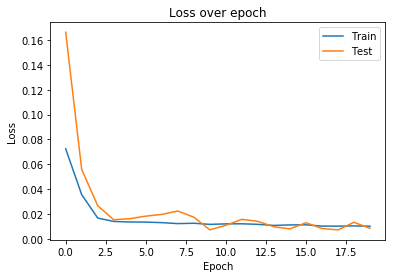

In [39]:
plot_history(history)

Test RMSE: 3707.762


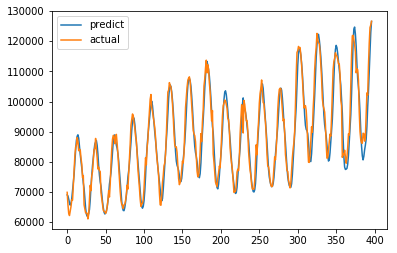

In [40]:
yhat_inverse = scalere.inverse_transform(yhat.reshape(-1, 1))
y_test_inverse = scalere.inverse_transform(y_test.reshape(-1, 1))

rmse = sqrt(mean_squared_error(y_test_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(y_test_inverse, label='actual')
pyplot.legend()
pyplot.show()

### RMSE for LSTM 3707. Is better but not fair enough

In [41]:
df = pd.read_csv('../../data/ads_hour.csv',index_col=['Date'], parse_dates=['Date'])

In [42]:
from sklearn.preprocessing import MinMaxScaler
X = df['ads'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

X.shape, df['ads'].shape

((2085, 1), (2085,))

In [43]:
#test_index = round(0.8*df.shape[0])

train_size = round(len(X) * 0.7)
test_size = len(X) - train_size
train, test = X[0:train_size,:], X[train_size:len(X),:]
print(len(train), len(test))

1460 625


In [44]:
def create_dataset(dataset, look_back=360):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [45]:
look_back = 5
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1455, 5), (1455,), (620, 5), (620,))

In [46]:
# Making 3D vector 
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape

((1455, 1, 5), (620, 1, 5))

In [47]:
# ------- Building the LSTM model --------- #

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_test, y_test), 
                                                                    verbose=0, shuffle=False)

# ------- Building the LSTM model --------- #

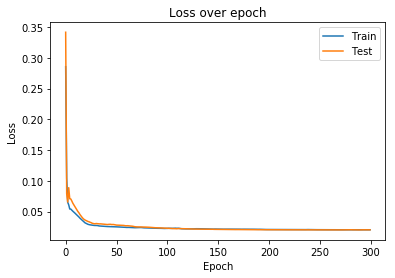

Test RMSE: 2891.869


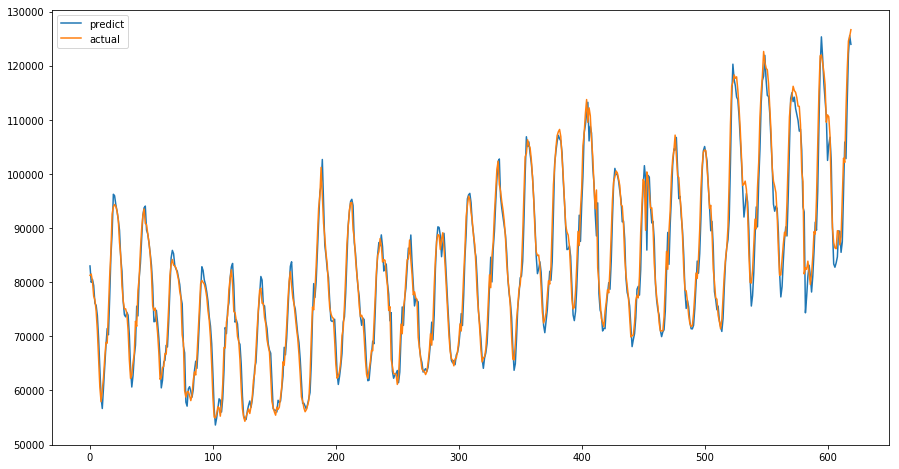

In [48]:
plot_history(history)
plot(X_test)

### Finaly we got good results with RMSE = 2891

##### In conclusion,
we can say that RNNs are pretty good instrument for predicting time series. It has pros and cons.
It could give very good results because LSTM remember previos periods, peaks, trens and other moments. 
More than 1000 parameters to tune model makes choise of LSTM in simple time prediction hard. You can change numer of layes, choose dropout, window size, optimizer, bathc size, number of epochs, return or not renurn sequences.
<It seems, that choose of LSTM is good, when ARIMA, SARIMA, Prophet aren't give acceptable metrics and results. Or when we have lots of additional information to Time series. For example: Using News to Predict Stock Movements, of sales with lots of conditions from business that describe different changes in Time Series.

### References

http://datareview.info/article/znakomstvo-s-arhitekturoy-lstm-setey/
https://cyberleninka.ru/article/v/prognozirovanie-tendentsii-finansovyh-vremennyh-ryadov-s-pomoschyu-neyronnoy-seti-lstm
http://alexsosn.github.io/ml/2015/11/17/LSTM.html
https://github.com/rishikksh20/LSTM-Time-Series-Analysis/blob/master/LSTM_Time_Series_Analysis.ipynb
https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f